# 2009
## START: 73124


In [1]:
%run ../../src/start.py


python	3.9.6 (default, Jul 30 2021, 16:35:19) 
[GCC 7.5.0]
---------------------
Versions:
----------------------
pandas      1.3.1
numpy       1.20.3
matplotlib  3.4.2
seaborn     0.11.1
plotly      5.1.0
boto3       1.18.16
awswrangler 2.10.0
----------------------


Loaded Libraries
-------------------
import pandas as pd
import numpy as np
import sys,os
import re
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


## AWS
import boto3
import awswrangler as wr
----------------


GLOBAL VARIABLES
--------------------------
# Creating the low level functional client
client = boto3.client(
    's3',
    aws_access_key_id = AWS_KEY_ID,
    aws_secret_access_key = AWS_SECRET,
)
    
# Creating the high level object oriented interface
resource = boto3.resource(
    's3',
    aws_access_key_id = AWS_KEY_I

## Load Data

In [2]:
# year file
year = '2009'

In [3]:
# helper function
def bucket_raw_path(bucket_name,path_dir):
    ''''''
    raw_path = f's3://{bucket_name}/{path_dir}'
    return raw_path

In [4]:
raw = bucket_raw_path('dend-data',f'capstone/raw-data/crime-data/{year}')
raw

's3://dend-data/capstone/raw-data/crime-data/2009'

## List objects in bucket

In [5]:
wr.s3.list_objects(raw)

['s3://dend-data/capstone/raw-data/crime-data/2009/aug09mdb.xls',
 's3://dend-data/capstone/raw-data/crime-data/2009/dec09mdb.xls',
 's3://dend-data/capstone/raw-data/crime-data/2009/jul09mdb.xls',
 's3://dend-data/capstone/raw-data/crime-data/2009/nov09mdb.xls',
 's3://dend-data/capstone/raw-data/crime-data/2009/oct09mdb.xls',
 's3://dend-data/capstone/raw-data/crime-data/2009/sep09mdb.xls']

In [6]:
wr.s3.list_objects(raw,'xls')

['s3://dend-data/capstone/raw-data/crime-data/2009/aug09mdb.xls',
 's3://dend-data/capstone/raw-data/crime-data/2009/dec09mdb.xls',
 's3://dend-data/capstone/raw-data/crime-data/2009/jul09mdb.xls',
 's3://dend-data/capstone/raw-data/crime-data/2009/nov09mdb.xls',
 's3://dend-data/capstone/raw-data/crime-data/2009/oct09mdb.xls',
 's3://dend-data/capstone/raw-data/crime-data/2009/sep09mdb.xls']

## Create dataframe from s3 files

In [7]:
def s3_files_to_df(s3_files_path):
    ''' load s3 file path from wr result
    returns a dataframe of concat files '''
    df_list = []
    for i in wr.s3.list_objects(s3_files_path):
        temp = wr.s3.read_excel(i)
        df_list.append(temp)
    # create df from list files
    df = pd.concat(df_list, ignore_index=True)
    return df

In [8]:
%%time
df = s3_files_to_df(raw)

CPU times: user 1.86 s, sys: 41.6 ms, total: 1.9 s
Wall time: 11.5 s


In [9]:
#pip install xlrd

In [10]:
## cleanup columns
df.columns = df.columns.str.lower().str.replace(' ','_').str.replace('\n','_').str.strip()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73124 entries, 0 to 73123
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           73124 non-null  object 
 1   hour           73124 non-null  int64  
 2   offense_type   73124 non-null  object 
 3   beat           73124 non-null  object 
 4   premise        73124 non-null  object 
 5   block_range    73124 non-null  object 
 6   street_name    73124 non-null  object 
 7   type           73124 non-null  object 
 8   suffix         73124 non-null  object 
 9   #_of_offenses  73124 non-null  float64
dtypes: float64(1), int64(1), object(8)
memory usage: 5.6+ MB


In [12]:
df.head()

,date,hour,offense_type,beat,premise,block_range,street_name,type,suffix,#_of_offenses
0,08/01/09 00:00:00,0,Robbery,3B30,210,3000-3099,DURHAM,DR,N,1.0
1,08/01/09 00:00:00,0,Robbery,6B60,20A,500-599,SEMINAR,DR,-,1.0
2,08/01/09 00:00:00,0,Robbery,6B30,18N,8300-8399,NORTH HOUSTON ROSSLYN,RD,-,1.0
3,08/01/09 00:00:00,0,Robbery,18F30,18A,6300-6399,SKYLINE,DR,-,1.0
4,08/01/09 00:00:00,0,Robbery,2A20,18N,5900-5999,FULTON,ST,-,1.0


## Show null data

In [13]:
df.apply(lambda x: sum(x.isnull()))

date             0
hour             0
offense_type     0
beat             0
premise          0
block_range      0
street_name      0
type             0
suffix           0
#_of_offenses    0
dtype: int64

In [14]:
# create null percentage of column as dataframe
null_per_df = pd.DataFrame(df.isna().mean().round(4) * 100)
# rename columns
null_per_df.rename(columns={'index': 'col_name', 0: 'null_percent'}, inplace=True)

# filter data <20% null values
per_filter = null_per_df.null_percent<=90
null_per_df[per_filter].sort_values(by='null_percent',ascending=False)

,null_percent
date,0.0
hour,0.0
offense_type,0.0
beat,0.0
premise,0.0
block_range,0.0
street_name,0.0
type,0.0
suffix,0.0
#_of_offenses,0.0


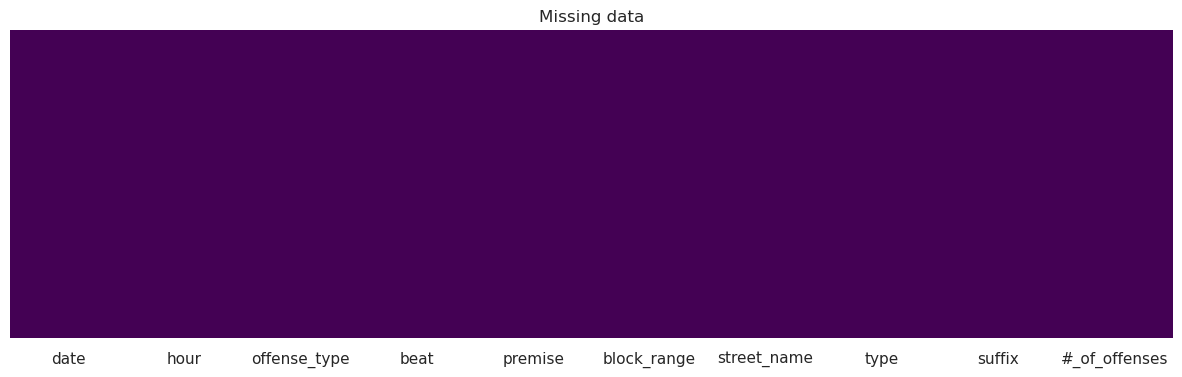

In [15]:
plt.figure(figsize=(15,4))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing data')
plt.show()

In [16]:
df.columns.tolist()

['date',
 'hour',
 'offense_type',
 'beat',
 'premise',
 'block_range',
 'street_name',
 'type',
 'suffix',
 '#_of_offenses']

In [17]:
# change column name
df = df.rename(columns={'#_of_offenses': 'offenses'})

In [18]:
df.columns.tolist()

['date',
 'hour',
 'offense_type',
 'beat',
 'premise',
 'block_range',
 'street_name',
 'type',
 'suffix',
 'offenses']

## Combine and drop columns

In [19]:
# # combine columns into a new one
# df['offenses'] = pd.concat([df['#_of_offenses'].dropna(),
#                               df['._of_offenses'].dropna()]).reindex_like(df)

# # drop columns
# df = df.drop(['#_of_offenses','._of_offenses'], axis = 1)

In [20]:
df.apply(lambda x: sum(x.isnull()))

date            0
hour            0
offense_type    0
beat            0
premise         0
block_range     0
street_name     0
type            0
suffix          0
offenses        0
dtype: int64

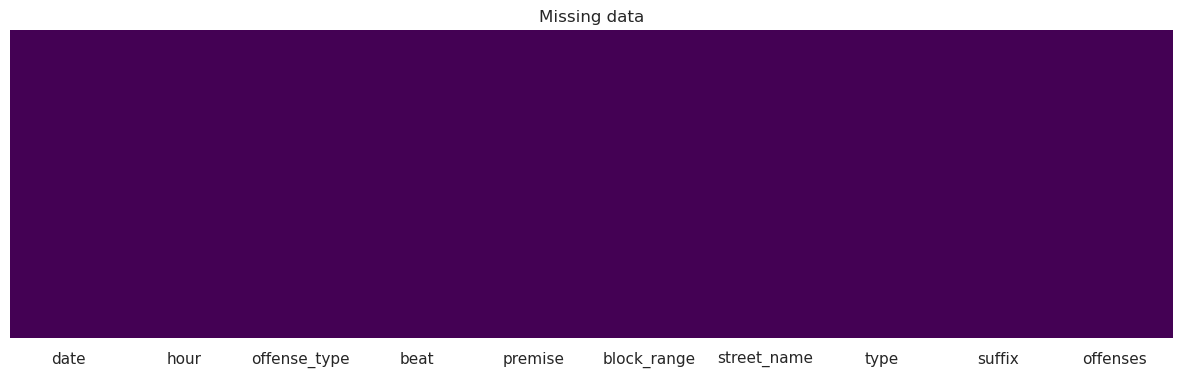

In [21]:
plt.figure(figsize=(15,4))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing data')
plt.show()

## Combine columns 

## Combine date & hour to one column

In [22]:
# convert two columns into one datetime
df['date_time'] = pd.to_datetime(df['date']) + pd.to_timedelta(df['hour'], unit='h')

# drop columns
#df = df.drop(['date','hour'], axis = 1)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73124 entries, 0 to 73123
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          73124 non-null  object        
 1   hour          73124 non-null  int64         
 2   offense_type  73124 non-null  object        
 3   beat          73124 non-null  object        
 4   premise       73124 non-null  object        
 5   block_range   73124 non-null  object        
 6   street_name   73124 non-null  object        
 7   type          73124 non-null  object        
 8   suffix        73124 non-null  object        
 9   offenses      73124 non-null  float64       
 10  date_time     73124 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(8)
memory usage: 6.1+ MB


In [24]:
df.head()

,date,hour,offense_type,beat,premise,block_range,street_name,type,suffix,offenses,date_time
0,08/01/09 00:00:00,0,Robbery,3B30,210,3000-3099,DURHAM,DR,N,1.0,2009-08-01
1,08/01/09 00:00:00,0,Robbery,6B60,20A,500-599,SEMINAR,DR,-,1.0,2009-08-01
2,08/01/09 00:00:00,0,Robbery,6B30,18N,8300-8399,NORTH HOUSTON ROSSLYN,RD,-,1.0,2009-08-01
3,08/01/09 00:00:00,0,Robbery,18F30,18A,6300-6399,SKYLINE,DR,-,1.0,2009-08-01
4,08/01/09 00:00:00,0,Robbery,2A20,18N,5900-5999,FULTON,ST,-,1.0,2009-08-01


## Convert offenses to integer

In [25]:
# convert offenses to int
df['offenses'] = df['offenses'].astype('int64')

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73124 entries, 0 to 73123
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          73124 non-null  object        
 1   hour          73124 non-null  int64         
 2   offense_type  73124 non-null  object        
 3   beat          73124 non-null  object        
 4   premise       73124 non-null  object        
 5   block_range   73124 non-null  object        
 6   street_name   73124 non-null  object        
 7   type          73124 non-null  object        
 8   suffix        73124 non-null  object        
 9   offenses      73124 non-null  int64         
 10  date_time     73124 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 6.1+ MB


# Create a year column
- to identify orgin of data

In [27]:
df['year'] = 2009

In [28]:
df.head()

,date,hour,offense_type,beat,premise,block_range,street_name,type,suffix,offenses,date_time,year
0,08/01/09 00:00:00,0,Robbery,3B30,210,3000-3099,DURHAM,DR,N,1,2009-08-01,2009
1,08/01/09 00:00:00,0,Robbery,6B60,20A,500-599,SEMINAR,DR,-,1,2009-08-01,2009
2,08/01/09 00:00:00,0,Robbery,6B30,18N,8300-8399,NORTH HOUSTON ROSSLYN,RD,-,1,2009-08-01,2009
3,08/01/09 00:00:00,0,Robbery,18F30,18A,6300-6399,SKYLINE,DR,-,1,2009-08-01,2009
4,08/01/09 00:00:00,0,Robbery,2A20,18N,5900-5999,FULTON,ST,-,1,2009-08-01,2009


## change order of columns

In [29]:
col_ord =['date_time','offenses','offense_type', 'block_range', 'street_name', 'type', 'suffix','beat', 'premise','date','hour','year']
df = df[col_ord]
df.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,date,hour,year
0,2009-08-01,1,Robbery,3000-3099,DURHAM,DR,N,3B30,210,08/01/09 00:00:00,0,2009
1,2009-08-01,1,Robbery,500-599,SEMINAR,DR,-,6B60,20A,08/01/09 00:00:00,0,2009
2,2009-08-01,1,Robbery,8300-8399,NORTH HOUSTON ROSSLYN,RD,-,6B30,18N,08/01/09 00:00:00,0,2009
3,2009-08-01,1,Robbery,6300-6399,SKYLINE,DR,-,18F30,18A,08/01/09 00:00:00,0,2009
4,2009-08-01,1,Robbery,5900-5999,FULTON,ST,-,2A20,18N,08/01/09 00:00:00,0,2009


0     4456
18    4422
22    4405
17    4132
20    4107
21    4038
19    4030
23    3821
12    3794
15    3506
16    3471
14    3263
13    2988
8     2779
11    2769
10    2708
7     2534
9     2373
1     2215
2     2084
6     1596
3     1449
4     1109
5     1075
Name: hour, dtype: int64

In [30]:
df.beat.value_counts(dropna=False)

19G10    1701
6B60     1609
12D10    1559
3B10     1471
1A20     1355
         ... 
21I20      38
21I60      34
21I70      10
21I40       2
23J40       1
Name: beat, Length: 118, dtype: int64

In [31]:
df.beat.unique()

array(['3B30', '6B60', '6B30', '18F30', '2A20', '6B10', '3B50', '19G40',
       '14D40', '14D20', '14D30', '1A50', '18F50', '18F20', '9C10',
       '16E30', '1A20', '5F20', '5F30', '17E10', '17E40', '2A60', '12D70',
       '20G50', '12D20', '8C50', '20G10', '10H60', '18F60', '18F40',
       '5F10', '7C50', '20G30', '16E20', '11H10', '17E20', '9C40',
       '20G60', '8C40', '11H30', '20G80', '6B50', '15E30', '1A30',
       '10H30', '13D20', '1A10', '19G20', '10H70', '12D10', '19G10',
       '3B10', '13D10', '7C30', '19G50', '5F40', 'UNK', '15E10', '16E40',
       '7C20', '14D10', '19G30', '3B40', '7C40', '21I50', '20G20', '8C10',
       '11H20', '20G40', '7C10', '12D50', '6B20', '9C20', '2A50', '2A10',
       '2A30', '12D30', '15E40', '12D40', '4F20', '12D60', '14D50',
       '6B40', '9C30', '10H20', '10H80', '17E30', '8C30', '13D40',
       '10H40', '15E20', '21I30', '24C10', '16E10', '4F10', '24C40',
       '2A40', '10H50', '8C60', '8C20', '11H50', '24C30', '10H10',
       '11H40', '2

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73124 entries, 0 to 73123
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date_time     73124 non-null  datetime64[ns]
 1   offenses      73124 non-null  int64         
 2   offense_type  73124 non-null  object        
 3   block_range   73124 non-null  object        
 4   street_name   73124 non-null  object        
 5   type          73124 non-null  object        
 6   suffix        73124 non-null  object        
 7   beat          73124 non-null  object        
 8   premise       73124 non-null  object        
 9   date          73124 non-null  object        
 10  hour          73124 non-null  int64         
 11  year          73124 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 6.7+ MB


In [42]:
df.premise.unique()

array(['210', '20A', '18N', '18A', '20R', '040', '250', '070', '20D',
       '13R', '140', '11P', '03B', '09D', '18M', '240', '120', '05O',
       '02B', '05Z', '080', '18G', '18H', '01A', '20V', '18O', '18T',
       '05G', '18P', '20G', '18R', '060', '23S', '20L', '20P', '18U',
       '18C', '05R', '05L', '20C', '05T', '11R', '18L', '05W', '24J',
       '18W', '190', '13H', '13B', '14V', '05C', '170', '03S', '05H',
       '13S', '20W', '24E', '100', '22E', '20M', '01P', '22P', '24C',
       '22U', '24F', '05D', '20N', '18B', '09H', '13A', '22D', '11G',
       '05E', '01B', '24T', '05V', '05M', '05X', '05F', '11S', '24P',
       '19V', '05P', '11F', '24B', '09P', '24A', '02C', '24S', '05B',
       '18S', '05S', '22M', '05Q', '05N', '09R', '22H', '02S', '24V',
       '25V', '24G', '150', '160', '13T', '18D', '05A', '11C', '22C',
       '20H', '09V', '11L', '04V', '---', '05Y', '21V', '11V', '12V',
       '01K', '05U', '23C', 'RES', '22V', '25R', '01R', '01T'],
      dtype=object)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73124 entries, 0 to 73123
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date_time     73124 non-null  datetime64[ns]
 1   offenses      73124 non-null  int64         
 2   offense_type  73124 non-null  object        
 3   block_range   73124 non-null  object        
 4   street_name   73124 non-null  object        
 5   type          73124 non-null  object        
 6   suffix        73124 non-null  object        
 7   beat          73124 non-null  object        
 8   premise       73124 non-null  object        
 9   date          73124 non-null  object        
 10  hour          73124 non-null  int64         
 11  year          73124 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 6.7+ MB


In [47]:
df.loc[df.duplicated(keep='first'),:]

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,date,hour,year
250,2009-08-01 15:00:00,1,Theft,3500-3599,TERMINAL,RD,N,21I30,01A,08/01/09 00:00:00,15,2009
498,2009-08-02 01:00:00,1,Theft,5200-5299,PAGEWICK,DR,E,4F20,20D,08/02/09 00:00:00,1,2009
515,2009-08-02 02:00:00,1,Theft,5600-5699,SANTA CHRISTI,DR,-,16E40,20D,08/02/09 00:00:00,2,2009
641,2009-08-02 14:00:00,1,Theft,900-999,GESSNER,DR,-,20G50,24J,08/02/09 00:00:00,14,2009
717,2009-08-02 18:00:00,1,Theft,3600-3699,WOODCHASE,-,-,20G10,18A,08/02/09 00:00:00,18,2009
...,...,...,...,...,...,...,...,...,...,...,...,...
72331,2009-09-27 13:00:00,1,Theft,9400-9499,WEST SAM HOUSTON,PKWY,S,19G10,080,09/27/09 00:00:00,13,2009
72357,2009-09-26 21:00:00,1,Theft,1800-1899,HOLLYOAK,DR,-,4F30,18A,09/26/09 00:00:00,21,2009
72799,2009-09-29 15:00:00,1,Theft,12100-12199,KATY,FWY,-,20G60,18T,09/29/09 00:00:00,15,2009
73043,2009-09-30 08:00:00,1,Theft,9300-9399,WESTHEIMER,RD,-,18F40,18R,09/30/09 00:00:00,8,2009


In [48]:
df.drop_duplicates(keep='first',inplace=True)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72600 entries, 0 to 73123
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date_time     72600 non-null  datetime64[ns]
 1   offenses      72600 non-null  int64         
 2   offense_type  72600 non-null  object        
 3   block_range   72600 non-null  object        
 4   street_name   72600 non-null  object        
 5   type          72600 non-null  object        
 6   suffix        72600 non-null  object        
 7   beat          72600 non-null  object        
 8   premise       72600 non-null  object        
 9   date          72600 non-null  object        
 10  hour          72600 non-null  int64         
 11  year          72600 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 7.2+ MB


## Save to bucket

In [51]:
bucket = 'dend-data'
file_name = f'crime_{year}.csv'
path_to_save = f"s3://{bucket}/capstone/inter-data/crime-data/{file_name}"
path_to_save

's3://dend-data/capstone/inter-data/crime-data/crime_2009.csv'

In [52]:
%%time
wr.s3.to_csv(df, path_to_save, index=False)

CPU times: user 529 ms, sys: 30.8 ms, total: 560 ms
Wall time: 12.6 s


{'paths': ['s3://dend-data/capstone/inter-data/crime-data/crime_2009.csv'],
 'partitions_values': {}}

# Save Sample
- for testing
- not to load all data
- duh

In [53]:
sample_100 = df.sample(100)
sample_100.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise,date,hour,year
64428,2009-09-18 18:00:00,1,Burglary,3400-3499,NOAH,-,-,14D20,20G,09/18/09 00:00:00,18,2009
60303,2009-10-30 14:00:00,1,Burglary,7700-7799,CORPORATE,DR,-,19G10,20A,10/30/09 00:00:00,14,2009
51740,2009-10-08 18:00:00,1,Burglary,1600-1699,KIPLING,-,-,1A30,250,10/08/09 00:00:00,18,2009
42004,2009-11-17 15:00:00,1,Auto Theft,6100-6199,WESTHEIMER,RD,-,18F30,18R,11/17/09 00:00:00,15,2009
10914,2009-08-28 11:00:00,1,Aggravated Assault,4000-4099,MAIN,ST,-,10H40,13R,08/28/09 00:00:00,11,2009


# Save sample

In [54]:
bucket = 'dend-data'
file_name = f'crime_{year}.csv'
path_to_save = f"s3://{bucket}/capstone/sample-data/crime-data/{file_name}"
path_to_save

's3://dend-data/capstone/sample-data/crime-data/crime_2009.csv'

In [55]:
%%time
wr.s3.to_csv(sample_100, path_to_save, index=False)

CPU times: user 24.9 ms, sys: 0 ns, total: 24.9 ms
Wall time: 365 ms


{'paths': ['s3://dend-data/capstone/sample-data/crime-data/crime_2009.csv'],
 'partitions_values': {}}